# Simulation numérique – ProgFest 2025
---
Par Arthur Légaré, le 5 mars 2025.

*Le masculin est utilisé pour alléger le texte.*

# Pourquoi simuler en physique?
---

Curieux de nature, le physicien est porté à expérimenter avec toutes sortes de cossins à sa disposition. Toutefois, avec la maîtrise du langage mathématique, sa curiosité vient généralement à bout des expériences immédiatement accessibles : il devient donc urgent d'agrandir le carré de sable!

Venons-y : la physique comporte son lot de phénomènes qui sont décrits par des équations complexes, souvent difficiles, voire impossibles, à résoudre analytiquement. C'est là que la simulation numérique entre en jeu, notamment pour :
1) explorer des systèmes trop complexes pour admettre une solution exacte;
2) visualiser des dynamiques évolutives et leurs comportements émergents;
3) tester des hypothèses et comparer avec des résultats expérimentaux.

Certains puristes pourraient y voir là les contours d'une sacrification de la physmath sur l'autel de la *force brute*. Mais attention : l'usage des simulations ne relègue pas aux oubliettes la physmath. Au contraire, nous verrons plutôt que cette dernière demeure l'outil privilégié pour affuter notre intuition, guidant ainsi nos explorations numériques et facilitant l'interprétation des résultats.


# 1. Plan de match
---

Nous verrons trois exemples de simulations numériques sur des sujets des plus variés. Au terme de cet atelier, vous devriez voir qu'une même recette peut être suivie (voir annexe Z).

**a) Dynamique écologique** – Modélisation de la coopération entre espèces et ses effets sur le taux de survie.

**b) Échanges thermiques dans un bâtiment** – Comparaison entre différentes stratégies de chauffage.

**c) Modèle d’activité neuronale** – Quantification de la ressemblance avec la structure biologique observée.


# 2. Comment utiliser ce notebook
---
* Chaque simulation sera introduite par une brève présentation du problème et des équations associées.

* Le code principal est externalisé dans des fichiers Python (.py), améliorant la modularité du code. Ceci facilite ainsi l'exploration approfondie et l'implémentation de nouvelles simulations!

# 3. Exemples de simulations
---

In [23]:
# Importons quelques librairies utiles.
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import inc.functions as fc
import os
import time
import scipy as sp
import random

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 16

## 3.1 Simulation écologique : Pourquoi l'altruisme survit-il dans la nature?
---

Au premier abord, l'évolution semble favoriser les individus maximisant la survie de leur descendance ainsi que d'eux-mêmes. Comment se fait-il alors qu'on puisse observer très fréquemment des comportements altruistes dans la nature? 

La théorie de l'évolution semble donc poser un paradoxe : si la sélection naturelle élimine les moins performants, comment émergent des stratégies de partage de ressources entre des individus, en particulier si cela va au détriment de leur propre survie?

Cette simulation propose d'explorer cette question en modélisant un écosystème où différentes stratégies de survie coexistent et interagissent. En effet, la nature peut être vue comme un vaste jeu stratégique entre une multitude d'espèces interagissant entre elles soit par entraide, par compétition ou même par trahison!

<img src="inc/simul_chaos_lapino.png" width=500 height=400 />

Chaque individu adopte une stratégie de survie (ou comportement) face aux autres et tous les indidivus présentant une même telle stratégie sont vus comme appartanent à une même espèce. Voici trois espèces que nous tenterons de simuler :
* **Tit-for-tat (TFT) :** Coopère au premier échange, puis imite le comportement de son interlocuteur.
* **PushOver (PO) :** Coopère toujours, même lorsqu'il est exploité.
* **Judas (JD) :** Trahit systématiquement, profitant des autres sans jamais coopérer.

Les individus doivent se nourrir pour survivre, mais la nourriture est limitée. Certains chercheront à la partager, d’autres à jouer les fiers-à-bras et la monopoliser. Dans ce contexte, **quels comportements seront avantagés? La coopération peut-elle émerger malgré la présence de tricheurs?**

En observant l’évolution des populations dans le temps, nous verrons si la nature sélectionne réellement les plus égoïstes… ou si, au contraire, l’entraide peut s’avérer être une stratégie gagnante. 

In [ ]:
from simul_ecologie import *

%run simul_ecologie.py

In [ ]:
### INITIALISATION DE LA BOUFFE ###
food_group = [Food(canvas_width, canvas_height) for _ in range(initial_number_of_food)]

#Visualisation de la distribution initiale de la nourriture dans l'environnement
fig, ax = plt.subplots()
for food_element in food_group:
    ax.scatter(food_element.position[0], food_element.position[1])
ax.set_xlim(0, canvas_width)
ax.set_ylim(0, canvas_height)
plt.title("Distribution initiale de la nourriture")
plt.show()

In [ ]:
### INITIALISATION DES ANIMAUX (UN GROUPE PAR ESPÈCE) ###
group_TFT = [TFT() for i in range(initial_TFT_population)]  # = [TFT() for i in range(initial_number_of_animals//2)
group_PushOver = [PushOver() for i in range(initial_PO_population)]
group_Judas =  [Judas() for i in range(initial_JD_population)]
group_Random =  [Confused() for i in range(initial_RD_population)]
group_TFTT =  [TitforTwoTats() for i in range(initial_TFTT_population)]
group_all_unshuffled = group_TFT + group_PushOver + group_Judas + group_Random + group_TFTT
group_all = random.sample(group_all_unshuffled, len(group_all_unshuffled))# concaténation des deux espèces en une population initiale

all_animals_quadrated = create_quadrated_group(group_all)

nourriture_quadrated = create_quadrated_group(food_group)

#Boucle principale du simulateur
toda_population = []  # suivi en temps réel du nombre d'animaux dans la simulation
TFT_population = []
TFTT_population = []
PO_population = []
JD_population = []
RD_population = []
food_amount = []
naissances = []
info_animaux = []
timing = []
pos_x = []
pos_y = []
for i in tqdm(range(sim_duration)):
    if initial_PO_population != 0:
        pos_x.append(group_PushOver[0].position[0]) # le premier PO, on enregistre ses déplacements
        pos_y.append(group_PushOver[0].position[1])
    elif initial_TFT_population != 0:
        pos_x.append(group_TFT[0].position[0]) # le premier PO, on enregistre ses déplacements
        pos_y.append(group_TFT[0].position[1])

    TFT_cnt = 0
    TFTT_cnt = 0
    PO_cnt = 0
    JD_cnt = 0
    RD_cnt = 0
    
    for quadrant in all_animals_quadrated:
        for animal in quadrant:
            if animal.species == "TFT":
                TFT_cnt += 1
            if animal.species == "TFTT":
                TFTT_cnt += 1
            if animal.species == "PO":
                PO_cnt += 1
            if animal.species == "JD":
                JD_cnt += 1
            if animal.species == "RD":
                RD_cnt += 1

    TFT_population.append(TFT_cnt)
    TFTT_population.append(TFTT_cnt)
    PO_population.append(PO_cnt)
    JD_population.append(JD_cnt)
    RD_population.append(RD_cnt)
    toda_population.append(TFT_cnt + PO_cnt + JD_cnt + RD_cnt + TFTT_cnt)  # Suivi démographique de la population totale

    naissances_par_h = update_group(all_animals_quadrated, nourriture_quadrated, i, info_animaux)  # Actualisation des animaux et de la bouffe présente
    #timing.append(temps)
    food = sum([len(quad) for quad in nourriture_quadrated])
    food_amount.append(food)
    if i % period_food_spawn == 0 and sum([len(quad) for quad in nourriture_quadrated]) < max_amount_of_food:
        new_food = [Food(canvas_width, canvas_height) for _ in
                    range(new_food_per_spawn)]  # Apparition spontanée de bouffe
        add_elements_to_quadrated_group(nourriture_quadrated, new_food)  # Ajout sur l'échiquier



<img src="inc/simul_chaos_carte.png" width=500 height=500 />

### Deux espèces en présence :
TFT et rapace. en proportions différentes. 

#### Application de l'inégalité de Nash.
(Notions d'écologie et de théorie du jeu)

### Version simplifiée
d'un cas particulier dans le simulateur mis sur pied en Dynamique non linéaire et chaos (présenté au sympsium 2024). 

### Conclusions : 
qu'est-ce qui supporte l'émergence de comportements altruistes dans la nature. 

### Pour pousser plus loin

lectures : le gène égoïste, vidéo de Veritasium, article d'Axelrod. Projet de Chaos.

---
## 3.2 Échanges thermiques dans un bâtiment

### Problématique : mon coloc a l'habitude de descendre son chauffage au minimum et de fermer sa porte à son départ. Place au débat!
Quel est le scénario de chauffage est le **moins énergivore** : une désactivation du radiateur pour la journée ou une légère diminution de la température cible? 

### Hypothèses
1) **Loi de Fourier** pour la conduction de chaleur,
$
\frac{\text{d}U(t)}{\text{d}t} = \frac{\kappa A}{d}\Delta T,
$
 est le mode dominant de transfert thermique.

2) **Gaz parfait** : l'énergie interne,
$
\text{d}U = nC_v \text{d}T,
$
ne dépend que de la température de l'air.

3) **Temps de relaxation** thermique : le temps que prend une pièce pour uniformiser sa température est négligeable comparativement au temps caractéristique des transferts thermiques entre pièces, si bien que
$
\tau_{\mathrm{relax}} \ll \tau_{\mathrm{transfert}},
$
ce qui permet de désigner la température d'une pièce $i$ simplement par $T_i(t)$.

4) On considère qu'aucun échange d'air n'a lieu entre les pièces et que la quantité initiale est donc confinée à chaque pièce.



### Mathématisation du problème (voir annexe B pour détails)



**Sous forme scalaire :**
$$
\underbrace{C_i \frac{\text{d}T_i(t)}{\text{d}t}}_{\text{Inertie thermique}} = \underbrace{P_i(t)}_{\text{Chauffage}} - \underbrace{\sum_{j=i}^{N}K_{ij}T_j(t)}_{\text{Échanges thermiques par conduction entre les pièces}}  + \underbrace{\sum_{j=1}^{N}K_{\mathrm{ext},ij}(T_{\mathrm{ext}}-T_j(t))}_{\text{Chauffage du "deillors"}}
$$
**Sous forme matricielle :**
$$
C\frac{\text{d}\mathbf{T}(t)}{\text{d}t} = \mathbf{P}(t) - K\mathbf{T}(t) + K_{\mathrm{ext}}\left(T_{\mathrm{ext}} - \mathbf{T}(t)\right)
$$



In [19]:
from simul_chauffage import *

%run simul_chauffage.py

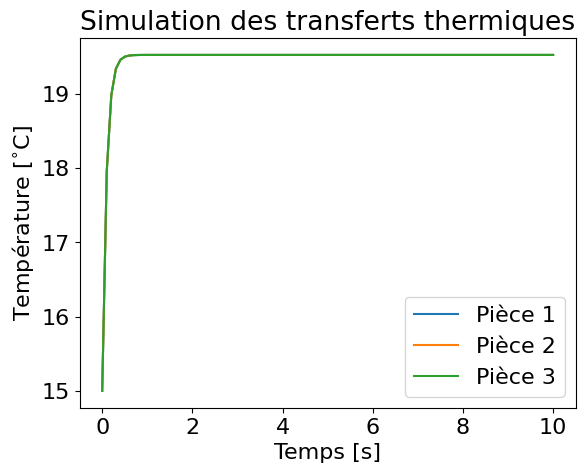

In [20]:

# Définir les paramètres
n_rooms = 3  # Nombre de pièces
C = np.diag([1.0, 1.0, 1.0])  # Matrice de capacités thermiques (valeurs d'exemple)
K = np.array([[2.0, -1.0, -1.0], [-1.0, 2.0, -1.0], [-1.0, -1.0, 2.0]])  # Matrice de conductance thermique (valeurs d'exemple)
K_ext = np.diag([0.5, 0.5, 0.5])  # Matrice de conductance thermique externe (valeurs d'exemple)

# Définir la fonction de température extérieure (exemple : température extérieure constante)
def T_ext_func(t):
    return np.array([10.0, 10.0, 10.0])

# Définir la fonction de puissance de chauffage (exemple : contrôle proportionnel)
def P_func(t, T):
    T_desired = np.array([20.0, 20.0, 20.0])
    K_p = 10.0
    return K_p * (T_desired - T)

# Vecteur de température initiale (valeurs d'exemple)
T0 = np.array([15.0, 15.0, 15.0])

# Vecteur de temps (valeurs d'exemple)
t = np.linspace(0, 10, 100)

# Simuler le modèle
T = simulate_thermal_model(C, K, K_ext, T_ext_func, P_func, T0, t)

# Afficher les résultats
plt.plot(t, T)
plt.xlabel("Temps [s]")
plt.ylabel(r"Température [$^{\circ}$C]")
plt.legend(["Pièce 1", "Pièce 2", "Pièce 3"])
plt.title('Simulation des transferts thermiques')
plt.show()


 # Extraire les séries temporelles de puissance pour obtenir ce réchauffement!
 # Intégrer les puissances des radiateurs
 # Comparer les énergie de chauffage pour les différents scénarios.

---
## c) Modèle d'Ising en 2D

### Phénoménologie selon la température.

### Visualisation
des patrons au seuil critique de changement de phase

### Modèle simplifié pour approcher le ferromagnétisme

### Finale :
qu'arrive-t-il si on introduit un champ magnétique. Réponse : revenez me voir dans quelques moi, je vais étudier le sujet de manière plus exhaustive.

# 4. Conclusion : Et si les simulations apprenaient d'elles-mêmes ?

Nous avons illustré au moyen de trois exemples en quoi les simulations numériques permettent de modéliser des systèmes complexes en physique. Mais que se passerait-il si, au lieu de coder explicitement chaque interaction, on laissait un modèle apprendre ces dynamiques?

C’est là qu’interviennent les réseaux neuronaux entraînés sur des modèles physiques. Plutôt que d’évaluer chaque équation pas à pas, on entraîne un réseau sur des données simulées. Une fois entraîné, le réseau tente de prédire l’évolution du système bien plus rapidement qu’une intégration numérique classique. 

En théorie, cette méthode est loin d'être farfelue, puisqu'on sait depuis 1989 [1] qu'un réseau neuronal peut agir à titre d'« approximateur universel » de toutes fonctions continues! Il est donc logique d'essayer de capturer la dynamique d'un système de cette manière.

Cette approche commence déjà à être utilisée pour accélérer les simulations en mécanique des fluides, en physique des matériaux, et même en cosmologie! <span style="color:red">sources</span>.


**Les PINNs : le bac à sable du futur**

Les simulations basées sur les équations (comme celles du présent atelier) sont complémentaires à celles basées sur l’apprentissage machine. En combinant la rigueur des modèles physiques avec la puissance des réseaux neuronaux, on ouvre la voie à des simulations 
1) plus rapides,
2) moins énergivores,
3) détenant la capacité de généraliser sur de nouveaux cas.
   
On parle alors de « réseaux de neurones informés par la physique », ou PINNs (*Physics-informed neural networks*) en anglais. <span style="color:red">sources</span>

# 5. Références
[1] G. Cybenko, “Approximation by superpositions of a sigmoidal function,” Math. Control Signal Systems, vol. 2, no. 4, pp. 303–314, Dec. 1989, doi: 10.1007/BF02551274.

[2] “Loi de refroidissement de Newton,” Wikipédia. Jul. 29, 2023. Accessed: Mar. 02, 2025. [Online]. Available: https://fr.wikipedia.org/w/index.php?title=Loi_de_refroidissement_de_Newton&oldid=206457504

[3] “Matrice laplacienne,” Wikipédia. Sep. 15, 2024. Accessed: Mar. 02, 2025. [Online]. Available: https://fr.wikipedia.org/w/index.php?title=Matrice_laplacienne&oldid=218663112

[4] E. W. Weisstein, “Positive Definite Matrix.” Accessed: Mar. 02, 2025. [Online]. Available: https://mathworld.wolfram.com/PositiveDefiniteMatrix.html

[5] “Thermal conduction,” Wikipedia. Feb. 25, 2025. Accessed: Mar. 02, 2025. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Thermal_conduction&oldid=1277574658

[6] I. Newton, “VII. Scala graduum caloris,” in Philosophical Transactions of the Royal Society of London, vol. 22, The Royal Society, 1701, pp. 824–829. doi: 10.1098/rstl.1700.0082.




# ANNEXES
## Annexe A

## Annexe B

### Modélisation des transferts thermiques par conduction dans un bâtiment

En combinant la loi de Fourier pour la conduction thermique et l'expression de variation d'énergie interne d'un gaz parfait pour un écoulement de temps $\text{d}t$, nous obtenons
$$
nC_v \text{d}T(t) = \frac{\kappa A}{d}\Delta T(t) \text{d}t \Longleftrightarrow nC_v \frac{\text{d}T(t)}{\text{d}t} = \frac{\kappa A}{d}\Delta T(t).
$$
Le taux de variation de température d'une pièce $i$ causé par le transfert thermique avec la pièce $j$ est proportionnel à la différence $\Delta T_{ij}(t) = -(T_i(t)-T_j(t))$, si bien que
$$
n_iC_v \frac{\text{d}T_i(t)}{\text{d}t} = -\underbrace{\frac{\kappa_{ij} A_{ij}}{d_{ij}}}_{\equiv l_{ij}}\Big(T_i(t) - T_j(t)\Big) = -l_{ij}\Big(T_i(t)-T_j(t)\Big).
$$
À ce stade, il est intéressant de remarque que cette relation est équivalente à la loi de refroidissement des corps, initialement formulée par Newton en 1701 [6].

Toutefois, nous souhaitons réexprimer cette équation au moyen d'une matrice de couplage globale qui encapsule tous les transferts thermiques par conduction, nous permettant ainsi d'éviter d'avoir recours à une différence de températures. On introduit donc la **matrice de conductivité thermique** $K$, construite comme suit :
$$
K_{ij} = \begin{cases} \sum_{j=1}^N l_{ij}(1-\delta_{ij}) \hspace{24pt} \text{si }i = j \; : \; \text{Transfert thermique vers les autres pièces.}\\ -l_{ij} \hspace{77pt} \text{si }i \neq j \; : \; \text{Loi de Fourier entre pièces }i\text{ et }j.\end{cases}
$$
Fait intéressant : la matrice de conductivité thermique $K$ correspond à une matrice de Laplace, qui est définie positive (c'est-à-dire ne possèdant que des valeurs propres positives). Ceci nous indique donc que sans l'intervention de radiateurs, les températures des pièces sont vouées à se stabiliser de manière monotone vers des valeurs d'équilibre thermique. Maintenant que nous avons posé la base des échanges thermiques, nous pouvons introduires les deux autres composantes-clés au modèle : la puissance de chauffage des radiateurs $\mathbf{P}(t)$ pour les $N$ pièces ainsi que le transfert thermique avec l'extérieur, de température $T_{\mathrm{ext}}$, qui peut être vu comme le "chauffage du deillors" en bon français.

# ANNEXE Z

### Recette : Comment réussir (ou pas) une simulation numérique

1. **Trouver un problème :** arroser les fleurs du tapis de la curiosité intellectuelle.
2. **Mathématiser le problème :** *soit un boeuf sphérique précédé d'une charrue...*
3. **Choisir des paramètres :** [*Itération 1*] partons à la cueillette de cerises, sans vergogne.
4. **Écrire une belle architecture** de code (digne du brutalisme, avec juste ce qu'il faut de chaos).
5. **Coder**, c’est-à-dire s'adonner à la chasse aux bugs en écoutant du [Georges Brassens](https://www.youtube.com/watch?v=oOPBnbNxLDM).
6. **Visualiser les résultats** (et ajuster les couleurs pour que ça ait l’air crédible).
